In [1]:
pip install numpy pandas scikit-learn tensorflow xgboost matplotlib

In [25]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers

In [28]:
df = pd.read_csv("/content/preprocessed_dataset.csv")  # adjust path if needed
X = df.drop(columns=["PotentialFraud"])
y = df["PotentialFraud"]


In [29]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

try:
    from xgboost import XGBClassifier
    XGB_AVAILABLE = True
except:
    XGB_AVAILABLE = False

In [30]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [31]:
# 3. Scale features
# =======================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


AUTO ENCODER

In [32]:
# 4. Build Autoencoder
# =======================
input_dim = X_train_scaled.shape[1]
encoding_dim = input_dim // 2 if input_dim > 2 else 1

input_layer = keras.Input(shape=(input_dim,))
encoded = layers.Dense(encoding_dim, activation="relu")(input_layer)
decoded = layers.Dense(input_dim, activation="sigmoid")(encoded)

autoencoder = keras.Model(input_layer, decoded)
encoder = keras.Model(input_layer, encoded)

autoencoder.compile(optimizer="adam", loss="mse")

In [33]:
# Train autoencoder
autoencoder.fit(X_train_scaled, X_train_scaled,
                epochs=20,
                batch_size=32,
                shuffle=True,
                validation_data=(X_test_scaled, X_test_scaled),
                verbose=1)



Epoch 1/20
13956/13956 ━━━━━━━━━━━━━━━━━━━━ 43s 3ms/step - loss: 0.7319 - val_loss: 0.6912
Epoch 2/20
13956/13956 ━━━━━━━━━━━━━━━━━━━━ 36s 3ms/step - loss: 0.6741 - val_loss: 0.6878
Epoch 3/20
13956/13956 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - loss: 0.6628 - val_loss: 0.6866
Epoch 4/20
13956/13956 ━━━━━━━━━━━━━━━━━━━━ 34s 2ms/step - loss: 0.6747 - val_loss: 0.6861
Epoch 5/20
13956/13956 ━━━━━━━━━━━━━━━━━━━━ 45s 3ms/step - loss: 0.6676 - val_loss: 0.6859
Epoch 6/20
13956/13956 ━━━━━━━━━━━━━━━━━━━━ 35s 3ms/step - loss: 0.6877 - val_loss: 0.6855
Epoch 7/20
13956/13956 ━━━━━━━━━━━━━━━━━━━━ 40s 2ms/step - loss: 0.6569 - val_loss: 0.6854
Epoch 8/20
13956/13956 ━━━━━━━━━━━━━━━━━━━━ 42s 3ms/step - loss: 0.6720 - val_loss: 0.6851
Epoch 9/20
13956/13956 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - loss: 0.6500 - val_loss: 0.6849
Epoch 10/20
13956/13956 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - loss: 0.6709 - val_loss: 0.6848
Epoch 11/20
13956/13956 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - loss: 0.6635 - val_loss: 0.68

In [34]:
# Encode features
X_train_encoded = encoder.predict(X_train_scaled)
X_test_encoded = encoder.predict(X_test_scaled)

13956/13956 ━━━━━━━━━━━━━━━━━━━━ 17s 1ms/step
3489/3489 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step


In [48]:
def evaluate_model(y_true, y_pred, model_name="Model"):
    print(f"\n===== Evaluation for {model_name} =====")

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average="weighted", zero_division=0)
    rec = recall_score(y_true, y_pred, average="weighted", zero_division=0)
    f1 = f1_score(y_true, y_pred, average="weighted", zero_division=0)

    print(f"Accuracy  : {acc:.4f}")
    print(f"Precision : {prec:.4f}")
    print(f"Recall    : {rec:.4f}")
    print(f"F1-score  : {f1:.4f}\n")

    print("Classification Report:")
    print(classification_report(y_true, y_pred, zero_division=0))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

RANDOM FOREST


In [38]:
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm
import numpy as np

class RFProgress(RandomForestClassifier):
    def fit(self, X, y, sample_weight=None):
        # override fit to include tqdm
        n_estimators = self.n_estimators
        self.set_params(warm_start=True)  # allows incremental training
        super().set_params(n_estimators=0)

        pbar = tqdm(total=n_estimators, desc="Training RF")
        for i in range(n_estimators):
            super().set_params(n_estimators=i+1)
            super().fit(X, y, sample_weight=sample_weight)
            pbar.update(1)
        pbar.close()
        return self

In [39]:
# Use this instead of RandomForestClassifier
rf = RFProgress(n_estimators=200, random_state=42)
rf.fit(X_train_encoded, y_train)


Training RF: 100%|██████████| 200/200 [14:52<00:00,  4.46s/it]


RFProgress(n_estimators=200, random_state=42, warm_start=True)


===== Evaluation for Random Forest =====
Accuracy  : 0.9929
Precision : 0.9929
Recall    : 0.9929
F1-score  : 0.9929

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     69083
           1       0.99      0.99      0.99     42560

    accuracy                           0.99    111643
   macro avg       0.99      0.99      0.99    111643
weighted avg       0.99      0.99      0.99    111643



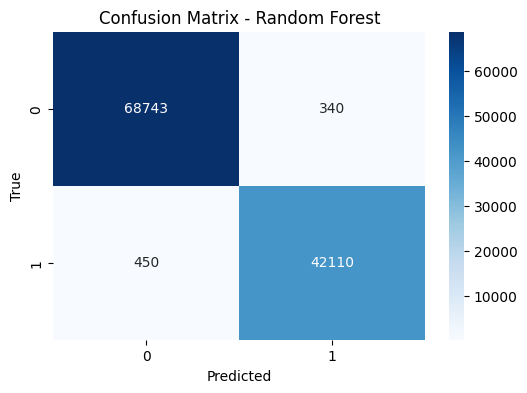

In [49]:
y_pred_rf = rf.predict(X_test_encoded)
evaluate_model(y_test, y_pred_rf, "Random Forest")

XGBOOST

In [41]:
from xgboost import XGBClassifier, callback
from tqdm import tqdm
import time

# Custom callback to use tqdm with XGBoost
class TQDMCallback(callback.TrainingCallback):
    def __init__(self, total):
        self.pbar = tqdm(total=total, desc="Training XGBoost")
    def after_iteration(self, model, epoch, evals_log):
        self.pbar.update(1)
        return False  # continue training
    def after_training(self, model):
        self.pbar.close()
        return model

In [42]:
# Initialize model
xgb = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    use_label_encoder=False,
    eval_metric="mlogloss"
)


In [45]:
# Train with progress bar
xgb.fit(
    X_train_encoded,
    y_train,
)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [11:00:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, ...)


===== Evaluation for XGBoost =====
Accuracy  : 0.9941
Precision : 0.9941
Recall    : 0.9941
F1-score  : 0.9941

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     69083
           1       0.99      0.99      0.99     42560

    accuracy                           0.99    111643
   macro avg       0.99      0.99      0.99    111643
weighted avg       0.99      0.99      0.99    111643



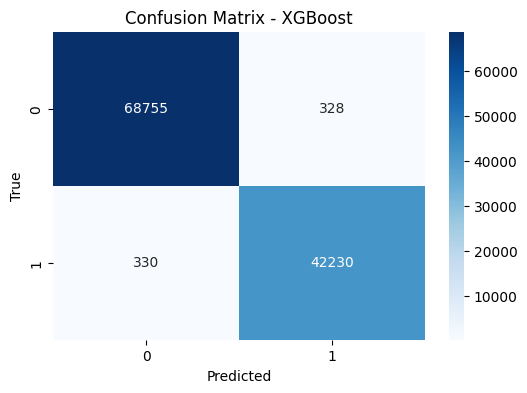

In [50]:
y_pred_xgb = xgb.predict(X_test_encoded)
evaluate_model(y_test, y_pred_xgb, "XGBoost")


===== Evaluation for RandomForest + Autoencoder =====
Accuracy  : 0.9929
Precision : 0.9929
Recall    : 0.9929
F1-score  : 0.9929

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     69083
           1       0.99      0.99      0.99     42560

    accuracy                           0.99    111643
   macro avg       0.99      0.99      0.99    111643
weighted avg       0.99      0.99      0.99    111643



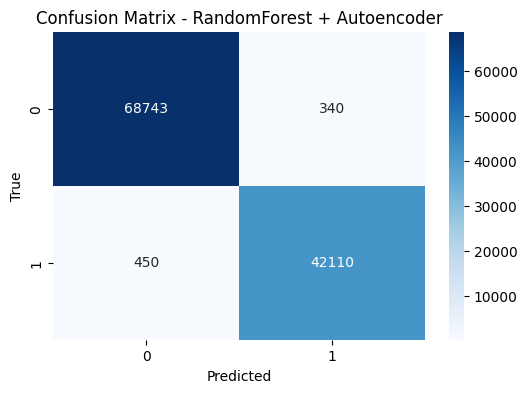


===== Evaluation for XGBoost + Autoencoder =====
Accuracy  : 0.9941
Precision : 0.9941
Recall    : 0.9941
F1-score  : 0.9941

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     69083
           1       0.99      0.99      0.99     42560

    accuracy                           0.99    111643
   macro avg       0.99      0.99      0.99    111643
weighted avg       0.99      0.99      0.99    111643



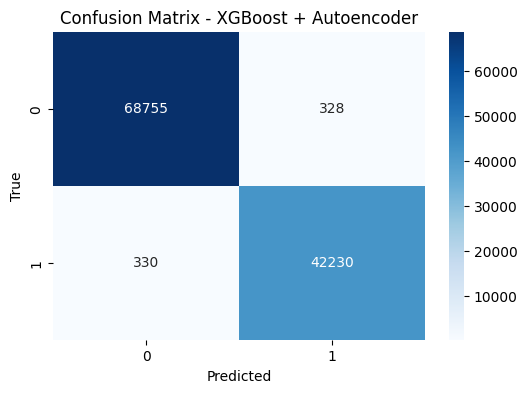

In [51]:
# 7. Evaluate Both Models
# =======================
evaluate_model(y_test, y_pred_rf, model_name="RandomForest + Autoencoder")
evaluate_model(y_test, y_pred_xgb, model_name="XGBoost + Autoencoder")